In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit,fsolve
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 12
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util_analysis_a24 as yu
yu.flag_fast=False

enss=['a24','a']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'B64','c':'C80','d':'D96'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96'}
ens2a={'a24':0.09471,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2}

# ens2mN={'a':931}
# ens2mpiC={'a':131}
# ens2mpi0={'a':111}

ens2amu={'a24':0.0053,'a':0.0009}
ens2ZP={'a24':(0.4670,0.0046),'a':(0.500,0.030)}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

def fsolve2(func,x0):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res=fsolve(func, x0)[0]
    return res if res!=x0 else np.NaN

ens='a24'

In [2]:
d_jk=6

path='/capstor/store/cscs/userlab/lp139/lyan/code/projectData_old/NST_all_data/NST_f_cA211.53.24_meson2pt.h5'
with h5py.File(path) as f:
    # print(f['diags/P/data'].keys())
    # print(f['diags/pi0f-pi0i/data'])
    # print(f['VEV/pi0f/data'].keys())
    
    cfgs_m2=[cfg.decode() for cfg in f['cfgs'][:]]
    
    imom=0
    c2pt_piC=yu.jackknife(f['diags/P/data/pi+_pi+'][:,:,imom],d=d_jk)
    c2pt_pi0=yu.jackknife(f['diags/P/data/pi0_pi0'][:,:,imom]+f['diags/pi0f-pi0i/data/pi0_pi0'][:,:,imom],d=d_jk)
    c2pt_sgm=yu.jackknife(f['diags/P/data/sgm_sgm'][:,:,imom]+f['diags/pi0f-pi0i/data/sgm_sgm'][:,:,imom],d=d_jk)
    
    c2pt_pi0_conn=yu.jackknife(f['diags/P/data/pi0_pi0'][:,:,imom],d=d_jk)
    
    vev_pi0=yu.jackknife(f['VEV/pi0f/data/pi0'][:],d=d_jk)
    vev_sgm=yu.jackknife(f['VEV/pi0f/data/sgm'][:],d=d_jk)
    
    if True: # symmetrize
        func=lambda t:(t+np.roll(np.flip(t,axis=1),1,axis=1))/2
        c2pt_piC=func(c2pt_piC)
        c2pt_pi0=func(c2pt_pi0)
        c2pt_sgm=func(c2pt_sgm)
        c2pt_pi0_conn=func(c2pt_pi0_conn)
        
    if True: # vev subtract
        c2pt_pi0 -= vev_pi0[:,None]**2
        c2pt_sgm -= vev_sgm[:,None]**2
        
    if True: # making real
        c2pt_piC=np.real(c2pt_piC)
        c2pt_pi0=np.real(c2pt_pi0)
        c2pt_sgm=np.real(c2pt_sgm)
        c2pt_pi0_conn=np.real(c2pt_pi0_conn)

Ncfg=len(cfgs_m2); Njk=len(c2pt_piC)
print(f'Ncfg={Ncfg}, Njk={Njk}')

Ncfg=2467, Njk=411


In [3]:
tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(ens2N_T[ens]-t))
tau=1
def C2pt2meff(C2pt):
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t

meff_piC=yu.jackmap(C2pt2meff,c2pt_piC)
meff_pi0=yu.jackmap(C2pt2meff,c2pt_pi0)
meff_sgm=yu.jackmap(C2pt2meff,c2pt_sgm)

meff_pi0_conn=yu.jackmap(C2pt2meff,c2pt_pi0_conn)

def run(meff,fitmins,fitmaxs):
    fits=[]
    fitress=[]
    for fitmin in fitmins:
        for fitmax in fitmaxs:
            fit_t=np.arange(fitmin,fitmax)
            fitfunc=lambda E: np.zeros(len(fit_t))+E
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,meff[:,fit_t],[0])
            
            fits.append([pars_jk,chi2_jk,Ndof])
            
            pars_mean,pars_err=yu.jackme(pars_jk)
            chi2_mean,chi2_err=yu.jackme(chi2_jk)
            
            fitress.append([(fitmin,fitmax),(pars_mean,pars_err),chi2_mean/Ndof])
            
    pars_jk,props_jk=yu.jackMA(fits)
    ind=np.argmax(yu.jackme(props_jk)[0])
    
    return (fitress,pars_jk,ind)
    
fitress_piC,E_piC,ind_piC=run(meff_piC,range(4,23),[24])
fitress_pi0,E_pi0,ind_pi0=run(meff_pi0,range(4,20),[21,22,23,24])
fitress_sgm,E_sgm,ind_sgm=run(meff_sgm,range(4,10),[11,12,13,14])

fitress_pi0_conn,E_pi0_conn,ind_pi0_conn=run(meff_pi0_conn,range(4,20),[21,22,23,24])

m_piC=346.60(35)
m_pi0=294.8(4.0)
m_sgm=688(15)
m_pi0_conn=470.71(65)


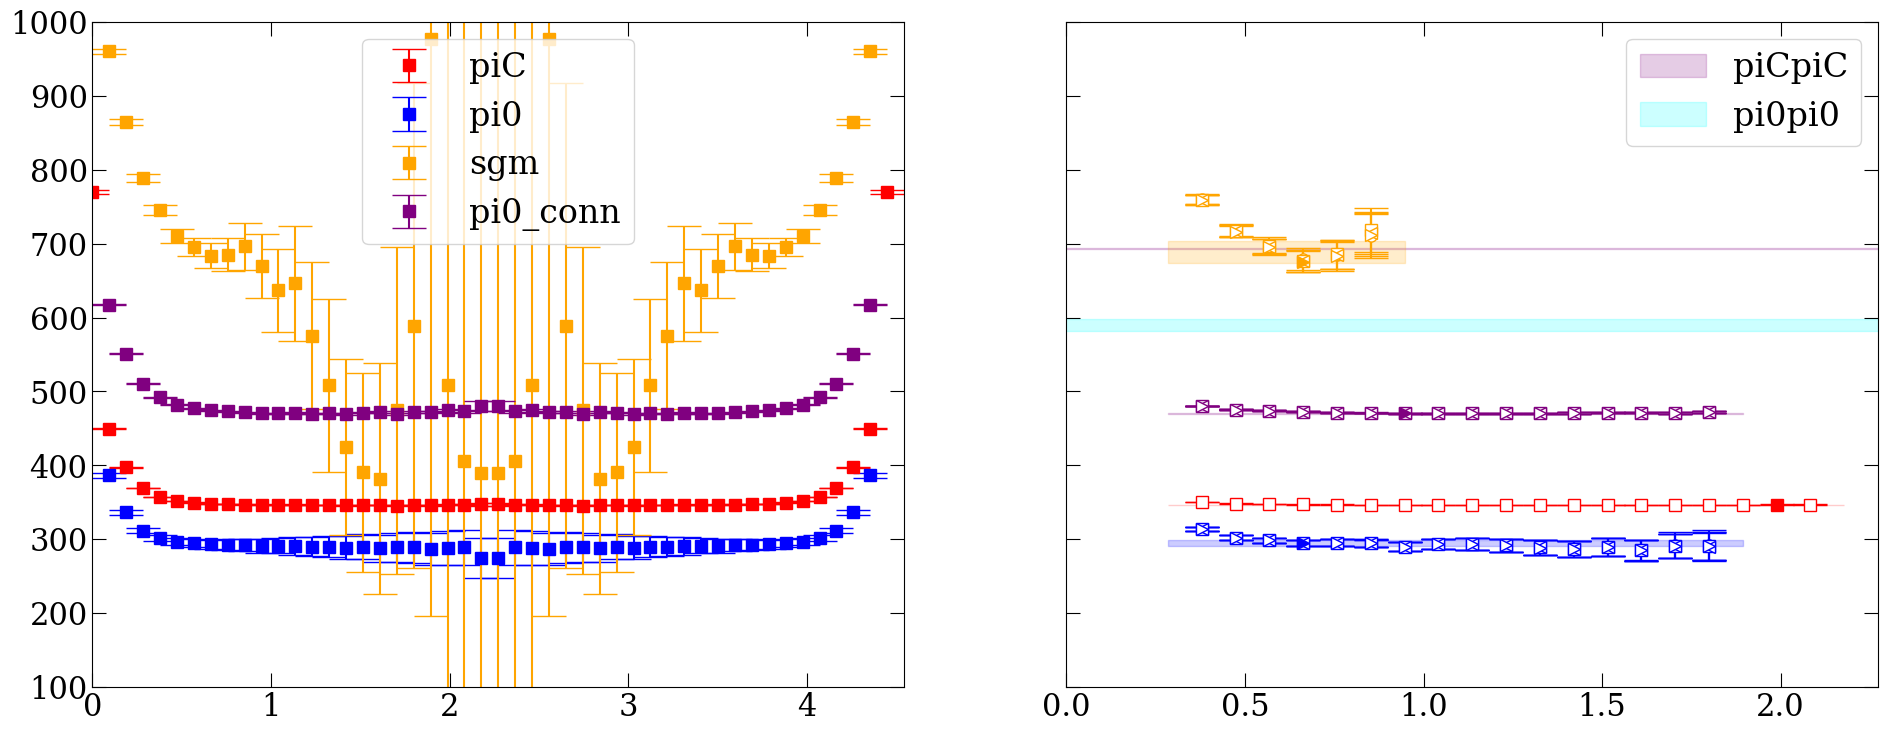

In [4]:
fig, axs = yu.getFigAxs(1,2,scale=1.5,sharey=True)

xunit=ens2a[ens]; yunit=ens2aInv[ens]

meff=meff_piC; color='r'; label='piC'
fitress,E,ind=fitress_piC,E_piC,ind_piC
ax=axs[0,0]
tmean,terr=yu.jackme(meff)
plt_x=np.arange(len(tmean))*xunit; plt_y=tmean*yunit; plt_yerr=terr*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=None,label=label)
ax=axs[0,1]
for i,fit in enumerate(fitress):
    fitmin,fitmax=fit[0]; E_mean,E_err=fit[1]; chi2R=fit[2]
    mfc=None if i==ind else 'white'
    plt_x=[fitmin*xunit]; plt_y=E_mean*yunit; plt_yerr=E_err*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc)
E_mean,E_err=yu.jackme(E)
E_mean_piC,E_err_piC=E_mean[0],E_err[0]
plt_x=np.array([3,23])*xunit; plt_y=E_mean*yunit; plt_error=E_err*yunit
ax.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color=color,alpha=0.2)
plt_x=np.array([-10,100])*xunit; plt_y=E_mean*yunit*2; plt_error=E_err*yunit*2
ax.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color='purple',alpha=0.2,label='piCpiC')


meff=meff_pi0; color='b'; label='pi0'
fitress,E,ind=fitress_pi0,E_pi0,ind_pi0
ax=axs[0,0]
tmean,terr=yu.jackme(meff)
plt_x=np.arange(len(tmean))*xunit; plt_y=tmean*yunit; plt_yerr=terr*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=None,label=label)
ax=axs[0,1]
for i,fit in enumerate(fitress):
    fitmin,fitmax=fit[0]; E_mean,E_err=fit[1]; chi2R=fit[2]
    mfc=None if i==ind else 'white'
    plt_x=[fitmin*xunit]; plt_y=E_mean*yunit; plt_yerr=E_err*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc,marker={21:'o',22:'s',23:'<',24:'>'}[fitmax])
E_mean,E_err=yu.jackme(E)
E_mean_pi0,E_err_pi0=E_mean[0],E_err[0]
plt_x=np.array([3,20])*xunit; plt_y=E_mean*yunit; plt_error=E_err*yunit
ax.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color=color,alpha=0.2)
plt_x=np.array([-10,100])*xunit; plt_y=E_mean*yunit*2; plt_error=E_err*yunit*2
ax.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color='cyan',alpha=0.2,label='pi0pi0')

meff=meff_sgm; color='orange'; label='sgm'
fitress,E,ind=fitress_sgm,E_sgm,ind_sgm
ax=axs[0,0]
tmean,terr=yu.jackme(meff)
plt_x=np.arange(len(tmean))*xunit; plt_y=tmean*yunit; plt_yerr=terr*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=None,label=label)
ax=axs[0,1]
for i,fit in enumerate(fitress):
    fitmin,fitmax=fit[0]; E_mean,E_err=fit[1]; chi2R=fit[2]
    mfc=None if i==ind else 'white'
    plt_x=[fitmin*xunit]; plt_y=E_mean*yunit; plt_yerr=E_err*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc,marker={11:'o',12:'s',13:'<',14:'>'}[fitmax])
E_mean,E_err=yu.jackme(E)
E_mean_sgm,E_err_sgm=E_mean[0],E_err[0]
plt_x=np.array([3,10])*xunit; plt_y=E_mean*yunit; plt_error=E_err*yunit
ax.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color=color,alpha=0.2)

meff=meff_pi0_conn; color='purple'; label='pi0_conn'
fitress,E,ind=fitress_pi0_conn,E_pi0_conn,ind_pi0_conn
ax=axs[0,0]
tmean,terr=yu.jackme(meff)
plt_x=np.arange(len(tmean))*xunit; plt_y=tmean*yunit; plt_yerr=terr*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=None,label=label)
ax=axs[0,1]
for i,fit in enumerate(fitress):
    fitmin,fitmax=fit[0]; E_mean,E_err=fit[1]; chi2R=fit[2]
    mfc=None if i==ind else 'white'
    plt_x=[fitmin*xunit]; plt_y=E_mean*yunit; plt_yerr=E_err*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc,marker={21:'o',22:'s',23:'<',24:'>'}[fitmax])
E_mean,E_err=yu.jackme(E)
E_mean_pi0_conn,E_err_pi0_conn=E_mean[0],E_err[0]
plt_x=np.array([3,20])*xunit; plt_y=E_mean*yunit; plt_error=E_err*yunit
ax.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color=color,alpha=0.2)

ax=axs[0,0]
ax.set_xlim([0,48*xunit])
ax.set_ylim([100,1000])
# ax.set_ylim([340,370])
ax.legend()
ax=axs[0,1]
ax.set_xlim([0,24*xunit])
ax.legend()

print(f'm_piC={yu.un2str(E_mean_piC*yunit,E_err_piC*yunit)}')
print(f'm_pi0={yu.un2str(E_mean_pi0*yunit,E_err_pi0*yunit)}')
print(f'm_sgm={yu.un2str(E_mean_sgm*yunit,E_err_sgm*yunit)}')

print(f'm_pi0_conn={yu.un2str(E_mean_pi0_conn*yunit,E_err_pi0_conn*yunit)}')

In [5]:
Tpack=16
path='/capstor/store/cscs/userlab/lp139/lyan/code/projectData_old/NST_all_data/NST_f_cA211.53.24_Nsgm.h5'
data=yu.load(path,d=d_jk)
assert(np.all(data['cfgs'][0]==cfgs_m2))

loading: /capstor/store/cscs/userlab/lp139/lyan/code/projectData_old/NST_all_data/NST_f_cA211.53.24_Nsgm.h5


193/193: diags/Z3pt/srcs/Z3pt.h5_NJNpi-f-Nsrc3*4-Nsigma                               


In [6]:
flags={
    'cc2pt':True, # average quantities related by complex conjugation for 2pt
    'cc3pt':True, # same for 3pt (Removal of vacuum expectation value requires 'cc2pt'=='cc3pt')
    'll2pt':True, # average irrep rows 'l1' and conjugated 'l2' (Parity breaking effect of tmQCD has been taken care of)
    'll3pt':True, # same for 3pt (This flag has no effect if 'll2pt'=True and spin-projection is done)
    'r2pt': True, # making 2ptMat real for the rest frame # 'll2pt' has to be real for this flag
    'remove_pi0VEV':True, 
    'remove_jVEV':True,
}

def op_remove_pi0(op):
    t=op.split(';')
    if t[-1] in ['p','n','n,pi+']:
        return False
    if t[3] not in ['N0pi0,a','N1pi0,a','N0sgm0,a','N1sgm0,a']:
        return False
    if t[3] in ['N0sgm0,a','N1sgm0,a']:
        t[3]='a'
        t[-1]={'p,sgm':'p'}[t[-1]]
        return ';'.join(t)
    if t[2] == 'G1u':
        t[2]='G1g'
        assert(t[3]=='N0pi0,a'); t[3]='a'
        assert(t[-1]=='p,pi0'); t[-1]='p'
        return ';'.join(t)

def get2pt_diag(opa,opb,diag):
    opab=f'{opa}_{opb}'
    if opab not in data['2pt'].keys() or diag not in data['2pt'][opab].keys():
        return 0
    res=data['2pt'][opab][diag].copy()
    if not flags['remove_pi0VEV']:
        return res
    if diag == 'pi0f-pi0i':
        if opa==opb and opa=='t;0,0,0;pi0':
            res -= (data['VEV']['pi0f']**2)[:,None]
        return res
    
    if 'pi0f' in diag.split('-'):
        t_opa=op_remove_pi0(opa)
        if t_opa != False:
            t=diag.split('-'); t.remove('pi0f'); t_diag='-'.join(t)
            res -= data['2pt'][f'{t_opa}_{opb}'][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None]
    if 'pi0i' in diag.split('-'):
        t_opb=op_remove_pi0(opb)
        if t_opb != False:
            t=diag.split('-'); t.remove('pi0i'); t_diag='-'.join(t)
            res -= data['2pt'][f'{opa}_{t_opb}'][t_diag] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
    if 'pi0f' in diag.split('-') and 'pi0i' in diag.split('-'):
        t_opa=op_remove_pi0(opa); t_opb=op_remove_pi0(opb)
        if t_opa != False and t_opb != False:
            t=diag.split('-'); t.remove('pi0f'); t.remove('pi0i'); t_diag='-'.join(t)
            res += data['2pt'][f'{t_opa}_{t_opb}'][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
    return res

def get2pt(opa,opb,diags=yu.diags_all):
    res=np.zeros([Njk,Tpack],dtype=complex)
    opab=f'{opa}_{opb}'; opba=f'{opb}_{opa}'
    if opab in data['2pt']:
        res+=np.sum([get2pt_diag(opa,opb,diag) for diag in data['2pt'][opab].keys() if diag in diags],axis=0)
    if opba in data['2pt']:
        diags_cc={'T', 'T-pi0f'}; 
        res+=np.conj(np.sum([get2pt_diag(opa,opb,diag) for diag in data['2pt'][opba].keys() if diag in diags_cc and diag in diags],axis=0))
    return res

def get2ptMat(ops,diags=yu.diags_all):
    if flags['ll2pt']:
        flags['ll2pt']=False
        ops_flip=[yu.op_flipl(op) for op in ops]
        t=(get2ptMat(ops,diags=diags)+np.conj(get2ptMat(ops_flip,diags=diags)))/2
        flags['ll2pt']=True
        if ops[0].split(';')[1]=='0,0,0' and flags['r2pt']:
            t=np.real(t)
        return t
    t=np.transpose([[get2pt(opa,opb,diags) for opb in ops] for opa in ops],[2,3,0,1])
    if flags['cc2pt']:
        t=(t+np.conj(np.transpose(t,[0,1,3,2])))/2
    return t

tfs=[10,12,14]

def get3pt_diag(opa,opb,insert,diag):
    opab=f'{opa}_{opb}'
    if opab not in data['3pt'].keys() or diag not in data['3pt'][opab][insert].keys():
        return 0
    res=data['3pt'][opab][insert][diag].copy()
    if flags['remove_pi0VEV']:
        if 'pi0f' in diag.split('-'):
            t_opa=op_remove_pi0(opa)
            if t_opa != False:
                t=diag.split('-'); t.remove('pi0f'); t_diag='-'.join(t)
                res -= data['3pt'][f'{t_opa}_{opb}'][insert][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None]
        if 'pi0i' in diag.split('-'):
            t_opb=op_remove_pi0(opb)
            if t_opb != False:
                t=diag.split('-'); t.remove('pi0i'); t_diag='-'.join(t)
                res -= data['3pt'][f'{opa}_{t_opb}'][insert][t_diag] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
        if 'pi0f' in diag.split('-') and 'pi0i' in diag.split('-'):
            t_opa=op_remove_pi0(opa); t_opb=op_remove_pi0(opb)
            if t_opa != False and t_opb != False:
                t=diag.split('-'); t.remove('pi0f'); t.remove('pi0i'); t_diag='-'.join(t)
                res += data['3pt'][f'{t_opa}_{t_opb}'][insert][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
    if flags['remove_jVEV']:
        gm,j,tf=insert.split('_')
        t_insert='_'.join([gm,j])
        if 'j' in diag.split('-') and t_insert in ['id_j+','g5_j-']:
            t=diag.split('-'); t.remove('j'); t_diag='-'.join(t)
            res -= (get2pt_diag(opa,opb,t_diag)[:,int(tf)] * data['VEV']['j'][t_insert])[:,None]
    return res

def get3pt(opa,opb,insert,diags=yu.diags_all):
    res=np.zeros([Njk,int(insert.split('_')[-1])+1],dtype=complex)
    opab=f'{opa}_{opb}'; opba=f'{opb}_{opa}'
    if opab in data['3pt']:
        res+=np.sum([get3pt_diag(opa,opb,insert,diag) for diag in data['3pt'][opab][insert].keys() if diag in diags],axis=0)
    if opba in data['3pt']:
        t=data['3pt'][opb+'_'+opa][insert]; 
        diags_cc={'B3pt','W3pt','Z3pt','T-j', 'T-pi0f-j','T-jPf','B3pt-pi0f','W3pt-pi0f','Z3pt-pi0f'}; 
        if opab not in data['3pt'] or 'NJN-pi0f' not in data['3pt'][opab][insert]:
            diags_cc.add('NJN-pi0i')
        t_add=np.zeros([Njk,int(insert.split('_')[-1])+1],dtype=complex)+np.sum([get3pt_diag(opb,opa,insert,diag) for diag in t.keys() if diag in diags_cc and diag in diags],axis=0)
        res+=np.conj(t_add[:,::-1])*(yu.gtCj[insert.split('_')[0]])
    return res

def get3ptMat(opas,opbs,insert,diags=yu.diags_all):
    if flags['ll3pt']:
        flags['ll3pt']=False
        opas_flip=[yu.op_flipl(op) for op in opas]; opbs_flip=[yu.op_flipl(op) for op in opbs]
        sgns=np.array([[yu.op_getl_sgn(opa)*yu.op_getl_sgn(opb) for opb in opbs] for opa in opas])
        sgns*=yu.fourCPTstar[insert.split('_')[0]]
        t=(get3ptMat(opas,opbs,insert,diags=diags)+np.conj(get3ptMat(opas_flip,opbs_flip,insert,diags=diags))*sgns[None,None,:,:])/2
        flags['ll3pt']=True
        return t
    t=np.transpose([[get3pt(opa,opb,insert,diags) for opb in opbs] for opa in opas],[2,3,0,1])
    if flags['cc3pt']:
        flags['cc3pt']=False
        tt=get3ptMat(opbs,opas,insert,diags)[:,::-1]*(yu.gtCj[insert.split('_')[0]])
        flags['cc3pt']=True
        t=(t+np.conj(np.transpose(tt,[0,1,3,2])))/2
    return t


In [7]:
diags=yu.diags_all
ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']

c2ptM=get2ptMat(ops)
c3ptM=[get3ptMat(ops,ops,f'id_j+_{tf}',diags=diags) for tf in tfs]

ratio=[np.real(c3ptM[i_tf][:,:,0,0])/np.real(c2ptM[:,tf,0,0][:,None]) for i_tf,tf in enumerate(tfs)]


GEVP_t0=3
def func(c2ptM):
    evals,evecs=yu.GEVP(c2ptM,GEVP_t0)
    En=np.log(evals/np.roll(evals,-1,axis=0))
    t=evecs[:,:,0]
    evecs=np.abs(evecs/t[:,:,None])
    res=np.concatenate([En,evecs[:,:,1]],axis=1)
    res=np.real(res)
    return res
resGEVP=yu.jackmap(func,c2ptM)

def get(i_tf):
    tf=tfs[i_tf]
    evec=np.real(resGEVP[:,tf,2])
    # evec=np.real(resGEVP[:,14,2])
    c3pt=c3ptM[i_tf][:,:,0,0]+ evec[:,None]*c3ptM[i_tf][:,:,0,1] + evec[:,None]*c3ptM[i_tf][:,:,1,0]
    c2pt=c2ptM[:,tf,0,0] + evec*c2ptM[:,tf,0,1] + evec*c2ptM[:,tf,1,0] + evec**2*c2ptM[:,tf,1,1]
    return np.real(c3pt)/np.real(c2pt)[:,None]

ratioGEVP=[get(i_tf) for i_tf,tf in enumerate(tfs)]


fig, axs = yu.getFigAxs(1,1)
colorMap_rainbow={('noGEVP',10):'green',('noGEVP',12):'blue',('noGEVP',14):'purple',('GEVP',10):'magenta',('GEVP',12):'orange',('GEVP',14):'red'}
colorMap_rainbow={('noGEVP',10):'r',('noGEVP',12):'g',('noGEVP',14):'b',('GEVP',10):'r',('GEVP',12):'g',('GEVP',14):'b'}
xunit=ens2a[ens]; yunit=ens2amu[ens]*ens2aInv[ens]
ax=axs[0,0]

fmts=['s','o','d']

case='noGEVP'
mfc={'noGEVP':'white','GEVP':None}[case]
for i_tf,tf in enumerate(tfs):
    color=colorMap_rainbow[(case,tf)]
    mean,err=yu.jackme(ratio[i_tf])
    plt_x=np.arange(1 - tf//2,tf//2)*xunit; plt_y=mean[1:tf]*yunit; plt_yerr=err[1:tf]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc,fmt=fmts[i_tf],label=r'w/o $J_{N\sigma}$' if i_tf==0 else None)  
    
case='GEVP'
mfc={'noGEVP':'white','GEVP':None}[case]
for i_tf,tf in enumerate(tfs):
    color=colorMap_rainbow[(case,tf)]
    mean,err=yu.jackme(ratioGEVP[i_tf])
    plt_x=np.arange(1 - tf//2,tf//2)*xunit; plt_y=mean[1:tf]*yunit; plt_yerr=err[1:tf]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc,fmt=fmts[i_tf],label=r'with $J_{N\sigma}$' if i_tf==0 else None)

ax.legend(fontsize=20)
ax.set_xlabel(r'$t_{ins}-t_{s}/2$ [fm]')
ax.set_ylabel(r'$\sigma_{\pi N}(m_\pi=346)$ [MeV]')

path='fig/sgmA24.pdf'
plt.savefig(path,bbox_inches="tight")
plt.close()